<a href="https://colab.research.google.com/github/MiguelRochaBE/MotorImagery-BCI/blob/master/MI_BCI_DatasetAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Conexão ao Google Colab**

In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


## **Extrair base de dados do ficheiro zip**

Link: https://physionet.org/content/eegmmidb/1.0.0/

In [ ]:
!unzip -u "/content/drive/MyDrive/B(i)onitos/files.zip" -d "/content/drive/MyDrive"

## **Listar todos os ficheiros da base de dados**

In [13]:
import os

def run_fast_scandir(dir, ext):    # dir: str, ext: list
    subfolders, datafiles = [], []

    for f in os.scandir(dir):
        if f.is_dir():
            subfolders.append(f.path)
        if f.is_file():
            if os.path.splitext(f.name)[1].lower() in ext:
                datafiles.append(f.path)

    for dir in list(subfolders):
        sf, f = run_fast_scandir(dir, ext)
        subfolders.extend(sf)
        datafiles.extend(f)
    return subfolders, datafiles


subfolders, datafiles = run_fast_scandir('/content/drive/MyDrive/files', [".edf"])
#subfolders, eventfiles = run_fast_scandir('/content/drive/MyDrive/files', [".event"])

subfolders.sort()
datafiles.sort()
print(subfolders[:3])
print(datafiles[:3])


['/content/drive/MyDrive/files/S001', '/content/drive/MyDrive/files/S002', '/content/drive/MyDrive/files/S003']
['/content/drive/MyDrive/files/S001/S001R01.edf', '/content/drive/MyDrive/files/S001/S001R02.edf', '/content/drive/MyDrive/files/S001/S001R03.edf']


## **Biblioteca MNE: https://mne.tools/stable/index.html**


In [14]:
!pip install mne
import mne
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Desenhar filtro passa-banda**

Extracting EDF parameters from /content/drive/MyDrive/files/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 sec)



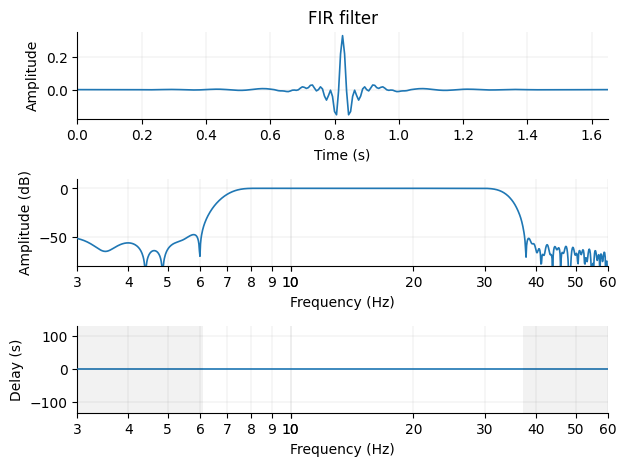

In [15]:
mne.set_log_level('INFO') #  Suprimir os logs das funções da biblioteca/ it can be either DEBUG, INFO, WARNING, ERROR, or CRITICAL

fmin = 8.
fmax = 30.
filter_design = 'firwin'
ska = 'edge'

raw = mne.io.read_raw_edf(datafiles[0], preload = False)

filter_params = mne.filter.create_filter(raw.get_data(), raw.info['sfreq'],l_freq=fmin, h_freq=fmax, fir_design = filter_design) # Criar filtro. É preciso dados como parâmetro
mne.viz.plot_filter(filter_params, raw.info['sfreq'], flim=(3, 60)) # Plot do filtro

mne.set_log_level('WARNING')

* Não há **delay** no filtro, ou seja, a fase do sinal em todas as frequências permance a mesma. Isto refere-se ao facto de certos filtros provocarem pequenos desvios na fase do sinal, o que levaria a que o instante em que é dada a 'cue' visual para o participante mover determinado membro deixasse de ficar sincronizado com o sinal do EEG, podendo interferir com as janelas de tempo das features de interesse.

* Outro aspeto importante é o filtro ser **FIR** e não **IIR**. Os filtros **IIR**, apesar de apresentarem bandas de transição inferiores, isto é, a transição entre as frequências que se querem manter e as frequências que se querem retirar ser mais íngreme, estes também são mais instáveis que os filtros **FIR**. Mais importante ainda, os filtros **IIR** apresentam desvios de fase não lineares, ou seja, a mudança de fase não é a mesma em todas as frequências, provocando desvios no sinal que são difícies de controlar. Já nos filtro **FIR**, o desvio na fase é linear sendo possível compensá-lo e anulá-lo muito mais facilmente, sendo computacionalmente mais eficiente fazê-lo e com erro nulo sabendo o valor deste desvio. Isto geralmente é feito automaticamente.

* O *filter_desing* é o *firwin* e não *firwin2* porque o primeiro apresenta menos amostras e possui um resultado quase idêntico. Isto será importante durante o processamento em tempo real dos nossos sinais.

## **Ler dados e separar/agrupar os blocos de EEG consoante o tipo/classe de movimento**

In [ ]:
def load_subject_data(subject, datafiles):

  '''
  Descrição dos eventos:

  Each annotation includes one of three codes (T0, T1, or T2):

    - T0 corresponds to rest
    - T1 corresponds to onset of motion (real or imagined) of the left fist (in runs 3, 4, 7, 8, 11, and 12)
                                                                    both fists (in runs 5, 6, 9, 10, 13, and 14)
    - T2 corresponds to onset of motion (real or imagined) of the right fist (in runs 3, 4, 7, 8, 11, and 12)
                                                                    both feet (in runs 5, 6, 9, 10, 13, and 14)
  '''

  trials = []
  for trial in datafiles: 
    if subject in trial: 
      trials.append(trial)
  
  print("Ficheiros a ler: ", trials)
  
  all_trials = [] # Variável com todos os blocos
  
  rest_events = 0 # Variáveis para contagem de eventos
  left_fist_events = 0
  right_fist_events = 0
  both_fists_events = 0
  both_feet_events = 0

  for count, trial  in enumerate(trials):
    if count > 1: # Avança os dois primeiros trials correspondentes ao rest
      raw_data = mne.io.read_raw_edf(trial, preload = True) # Dados EEG para um trial específico. 'Preload=True' serve para colocar o ficheiro na memória e não apenas referenciá-lo no diretório
      
      filtered_data = raw_data.copy().filter(fmin, fmax, fir_design=filter_design, skip_by_annotation=ska) # Filtrar os dados

      ch_names = filtered_data.ch_names # Elétrodos
      fs =  filtered_data.info.get('sfreq') # Frequência de amostragem
      annotations = filtered_data.annotations # Variável que contém os dados no tempo relativos aos blocos de movimentos executados
      
      trial_type1 = [3, 4, 7, 8, 11, 12]
      trial_type2 = [5, 6, 9, 10, 13, 14]

      # Atribuição das labels corretas aos eventos de cada trial

      trial_number = int(trial.split('.')[0][-2:]) # De 1 a 14; [0] corresponde à primeira parte da string original;
      print("Trial lido: ",trial_number)
      if trial_number in trial_type1:
        event_ids = {'T0': 1, 'T1': 2, 'T2': 3} # Dicionário com os ids dos eventos de acordo com a descrição a laranja ^^
        epoch_event_ids = {"rest/block": 1, "left_fist/block": 2, "right_fist/block": 3}
      elif trial_number in trial_type2:
        event_ids = {'T0': 1, 'T1': 4, 'T2': 5}
        epoch_event_ids = {"rest/block": 1, "both_fists/block": 4,"both_feet/block": 5}
      else:
        event_ids = {'T0': 1} # Dois primeiros trials de EEG

      events = mne.events_from_annotations(filtered_data, event_id = event_ids) # Variável eventos: Retorna 3 colunas [Indice da amostra onde começa o bloco, Trigger, Tipo de movimento (label)]
      
      # Agrupamento dos blocos do mesmo id (epoching)

      epochs = mne.Epochs(filtered_data, events[0], event_id = epoch_event_ids, tmin = 0., tmax = 3., detrend = 1, baseline = None, preload = True)
      
      # Contagem to tipo de eventos para verificar se há perda de informação durante a concatenação

      rest_events += epochs["rest"].__len__()
      if trial_number in trial_type1:
        left_fist_events += epochs["left_fist"].__len__()
        right_fist_events += epochs["right_fist"].__len__()
      else:
        both_fists_events += epochs["both_fists"].__len__()
        both_feet_events += epochs["both_feet"].__len__()

      if count == len(trials)-1:
        print("------------------------- Dados do último ficheiro lido -------------------------")
        print("\nInfo dos dados: ", raw_data.info)
        print("\nElétrodos: ", ch_names)
        print("\nAnotações: ", annotations.description)
        print("\nEventos: ", events)
        print("\nInformação dos blocos: ", epochs.info)
        print("\n")

        figure = mne.viz.plot_events(events[0]) # Gráfico dos eventos
        print("\n")
        filtered_data.plot(events=events[0]) # Plot dos dados com a speraração dos eventos

      all_trials.append(epochs)

  print("\nPré-concatenção de eventos: ")
  print("Número total de eventos: ", rest_events + left_fist_events + right_fist_events + both_fists_events + both_feet_events)
  print(f"Rest: {rest_events} -- Right Fist: {left_fist_events} -- Left Fist: {right_fist_events} -- Both Fists: {both_fists_events} -- Both Feet: {both_feet_events}")

  # Concatenação de todos os blocos

  subject_epochs = mne.concatenate_epochs(all_trials, add_offset = True, on_mismatch = 'raise')

  print("\nPós-concatenação de eventos: ")
  print("Número total de eventos: ", subject_epochs.__len__())
  print("Rest: ", subject_epochs["rest"].__len__())
  print("Right Fist: ", subject_epochs["right_fist"].__len__())
  print("Left Fist: ", subject_epochs["left_fist"].__len__())
  print("Both Fists: ", subject_epochs["both_fists"].__len__())
  print("Both Feet: ", subject_epochs["both_feet"].__len__())
  print("\n")

  print(np.shape(epochs))
  
  return subject_epochs, ch_names

subject_epochs, channels = load_subject_data(subfolders[10],datafiles)


* A filtragem é preferível fazer nos dados contínuos e não depois da segmentação. Isto tem a ver com o janelamento dos filtros, o qual neste caso usa a janela de **Hamming**. Isto é usado para fazer o *tappering* do sinal, ou seja, envolver o sinal numa janela para que as pontas fiquem a 0.

* Se isto não acontecesse, os filtros e, de forma geral, todos os métodos convolucionais de processamento de sinal (fft, wavelets, etc) provocariam artefactos enormes nas pontas do sinal.

* Os sinais sendo filtrados no segmento contínuo, a janela afeta maioritariamente a magnitude dos sinais da ponta, os quais são todos da classe redundante (nesto caso) rest. 

In [17]:
# Equaliza o nº de trials em todas as classes. A classe rest tinha muitos mais trials por exemplo.
# É importante que haja o mesmo nº de trials para cada classe durante a classificação
subject_epochs.equalize_event_counts() 

print("\nEqualização de eventos: ")
print("Rest: ", subject_epochs["rest"].__len__())
print("Right Fist: ", subject_epochs["right_fist"].__len__())
print("Left Fist: ", subject_epochs["left_fist"].__len__())
print("Both Fists: ", subject_epochs["both_fists"].__len__())
print("Both Feet: ", subject_epochs["both_feet"].__len__())
print("\n")

# Seleção de elétrodos
chan = mne.pick_channels(channels, include = ['C3..','Cz..','C4..'])
print("Indices: ", chan)

#dir(subject_epochs)


Equalização de eventos: 
Rest:  44
Right Fist:  44
Left Fist:  44
Both Fists:  44
Both Feet:  44


Indices:  [ 8 10 12]


In [ ]:
print("Condições: ",subject_epochs.event_id)
print("\nBlocos: ",subject_epochs.events)
subject_epochs["right_fist"].plot_image(picks=[chan[0]])

In [ ]:
dt = subject_epochs.to_data_frame()
print(dt.columns)
print("\n",dt)

In [ ]:
umcaso = mne.pick_events(events=subject_epochs.events)
subject_epochs['right_fist'].plot(events=umcaso, event_id=subject_epochs.event_id) #são 45 treinos

#print(subject_epochs['right_fist'][])
#(Talvez excluir os elétrodos que não vamos usar; não sei como.)

#Com isto, conseguimos ver cada epoch de cada movimento nos 64 elétrodos. Supostamente, com os 45 epochs, podíamos usá-los para fazer cross-validation.
#Mas como é que pegamos neles para fazer isso? Não são arrays numéricos, ou são? Se fossem, usando o sklearn não seria difícil ensinar.
#(A resposta deve ser simples, eu é que não sou muito experiente.)
#Outra questão: que modelo de treino usamos? Logistic Regression?
#Outra questão: na cross-validation, concatenam-se os 45 epochs (subject_epochs['right_fist'] em vez de subject_epochs['right_fist'][i])?
#Assinado: Samuel Neves.

In [11]:
print("[Trials, Elétrodos, Amostras] =",np.shape(subject_epochs.get_data()))

[Trials, Elétrodos, Amostras] = (220, 64, 481)


## **Dados Train/Test**

In [ ]:
def split_EEG(EEG_one_class, percent_train=0.8):
  print()

## **Extração de features com o Common Spatial Patterns (CSP)**

In [60]:
import numpy as np
from numpy import linalg
from scipy.linalg import sqrtm
from scipy.linalg import inv

# Mtrizes das covariâncias

def covariances(epoched_data):

  '''
  Cálculo das matrizes de covariância para cada classe
  '''

  classes = epoched_data.event_id
  n_trials, n_channels, n_samples = np.shape(epoched_data)
  n_trials = int(n_trials/len(classes))
  Trials_convs = np.zeros((n_trials, n_channels, n_channels))
  Class_convs = np.zeros((len(classes), n_channels, n_channels)) 
  # Pré alocação da variável 'convs'. Isto é boa prática fazer antes de qualquer ciclo para reduzir o tempo de processamento pré-alocando o array na memória.
  
  for mi_class, id in classes.items(): # Iteração de um dicionário
    Xc = epoched_data[mi_class].get_data()
    for trial in range(n_trials):
      Trials_convs[trial,:,:] = (Xc[trial,:,:] @ Xc[trial,:,:].T) / (np.trace (Xc[trial,:,:] @ Xc[trial,:,:].T))
    Class_convs[id-1,:,:] = np.mean(Trials_convs, axis = 0) # Média dos trials da mesma classe
    
  return Class_convs

# Whitening da matriz, ou seja, transformação que permite com que a matriz tenha a mesma covariância da matriz Identidade (I), logo covariâncias de 0 entre todos os pares

def decompose_cov(avg_cov):

    λ, V = np.linalg.eig(avg_cov) # λ são o eigenvalues e V os eigenvectors
    λ_desc = np.sort(λ)[::-1] 
    idx_desc = np.argsort(λ)[::-1] 
    V_desc = V[:, idx_desc] 
    λ_desc = np.diag(λ_desc) 
    
    return λ_desc, V_desc

def whitening(λ_desc, V_desc):

    λ_desc_sqr = sqrtm(inv(λ_desc))
    P = (λ_desc_sqr)@(V_desc.T)
    
    return P

Class_convs = covariances(subject_epochs)
Avg_convs = Class_convs.sum(axis = 0)
λ_desc, V_desc = decompose_cov(Avg_convs)
P = whitening(λ_desc, V_desc)

# Matriz S que contém os eigenvectors que maximizam a variância do EEG (freq) numa classe e minimiza noutra

def compute_S(avg_Cov, white):
    
    S = white@avg_Cov @ white.T
 
    return S

def decompose_S(S_one_class, order='d'):
  
    λ, B = np.linalg.eig(S_one_class)
    
    if order == 'a': # ascending
        idx = λ.argsort() 
    elif order == 'd': # descending
        idx = λ.argsort()[::-1] 
    else:
        print('Wrong order input')
    
    λ = λ[idx]
    B = B[:, idx]
    
    return B, λ 

classes = subject_epochs.event_id

# One-vs-the-rest CSP

B_one_class = np.zeros( (len(classes),len(subject_epochs.get_channel_types())) )
B_the_rest_classes = np.zeros( (len(classes),len(subject_epochs.get_channel_types())) )

for _, id in classes.items(): 

  one = compute_S(Class_convs[id-1,:,:],P)
  the_rest = compute_S(  np.sum(Class_convs[:(id-1),:,:], axis = 0) + np.sum(Class_convs[id:,:,:], axis = 0)  , P)

  λ_one, B_one = decompose_S(one, 'd')
  λ_the_rest, B_the_rest = decompose_S(the_rest, 'a')

  B_one_class[id-1,:] = B_one
  B_the_rest_classes[id-1,:] = B_the_rest
  
  #print("Valores antes: ", Class_convs[:(id-1),0,0])
  #print("Valor atual: ", Class_convs[id-1,0,0])
  #print("Valores depois: ", Class_convs[id:,0,0])
  print("Eigenvalues: ", B_one + B_the_rest)

# Filtro espacial (Matriz de projeção)

def spatial_filter(B, P):

    return (B.T @ P)

Eigenvalues:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Eigenvalues:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Eigenvalues:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Eigenvalues:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Eigenvalues:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.


* Os eigenvalues deram todos 1, logo está ✅



In [59]:
x = covariances(subject_epochs)
print()


64
